# Dataset analysis

In [1]:
import os
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import numpy as np

### Visualization of content

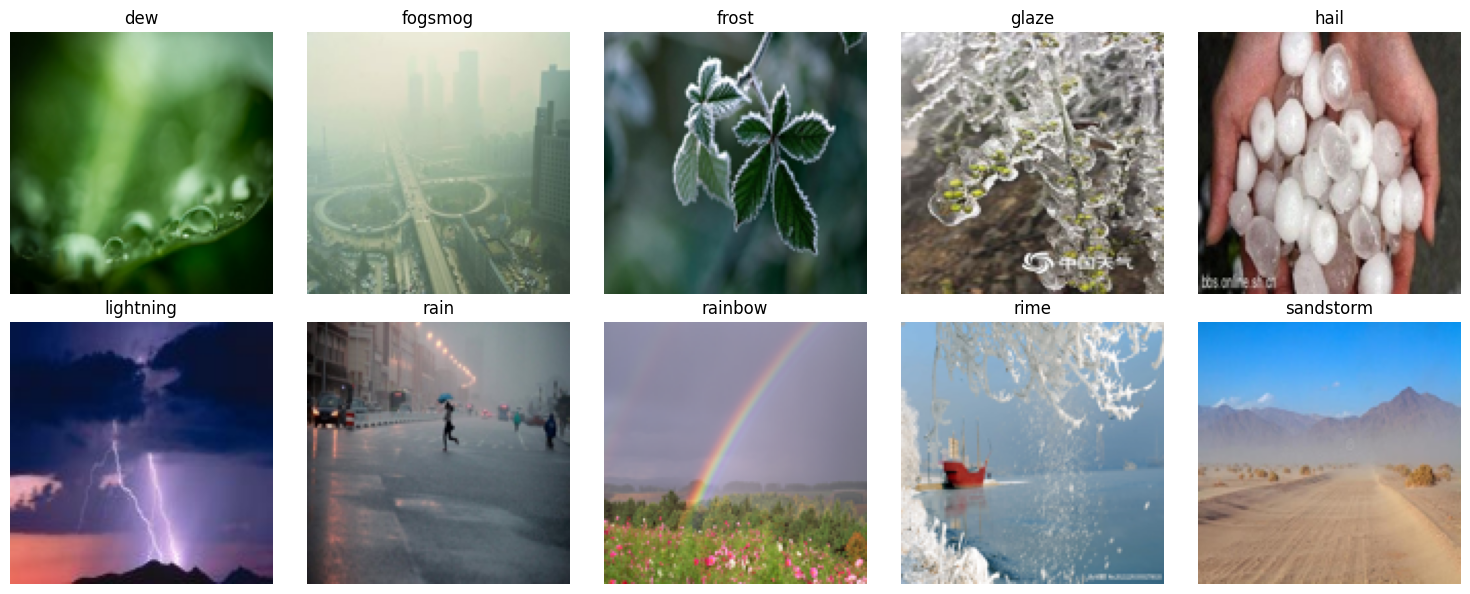

Figure Saved in ../reports/figures/dataset_analysis\example_from_each_class.svg


In [2]:
def show_examples_from_subfolders(folder_path, rows=2, cols=5, img_size=(128,128)):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    class_names = [os.path.basename(f) for f in subfolders]

    plt.figure(figsize=(15, 6))
    
    for i, (class_name, subfolder) in enumerate(zip(class_names, subfolders)):
        if i >= rows * cols:
            break
        
        files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
        img_path = os.path.join(subfolder, random.choice(files))
        
        img = Image.open(img_path).convert("RGB")
        img = img.resize(img_size)

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    
    plt.tight_layout()
    save_path = os.path.join("../reports/figures/dataset_analysis", f"example_from_each_class.svg")
    plt.savefig(save_path, format="svg")
    plt.show()
    plt.close()

    print(f"Figure Saved in {save_path}")

folder_path = "../dataset"
show_examples_from_subfolders(folder_path, rows=2, cols=5, img_size=(128,128))

### Class distribution

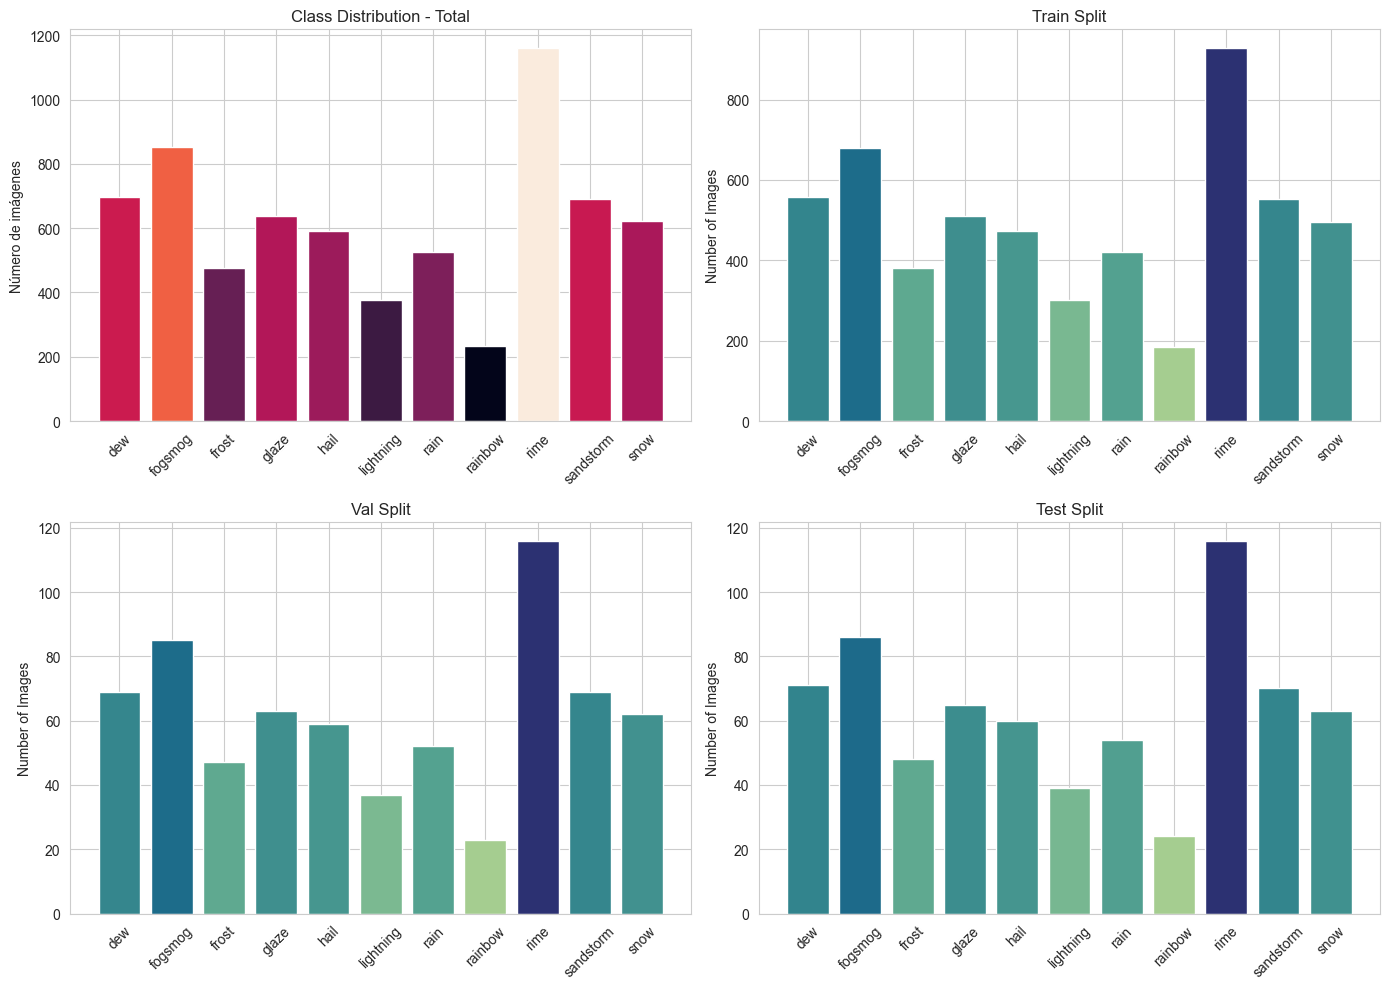

Figure Saved in ../reports/figures/dataset_analysis\class_distribution_barchart.svg


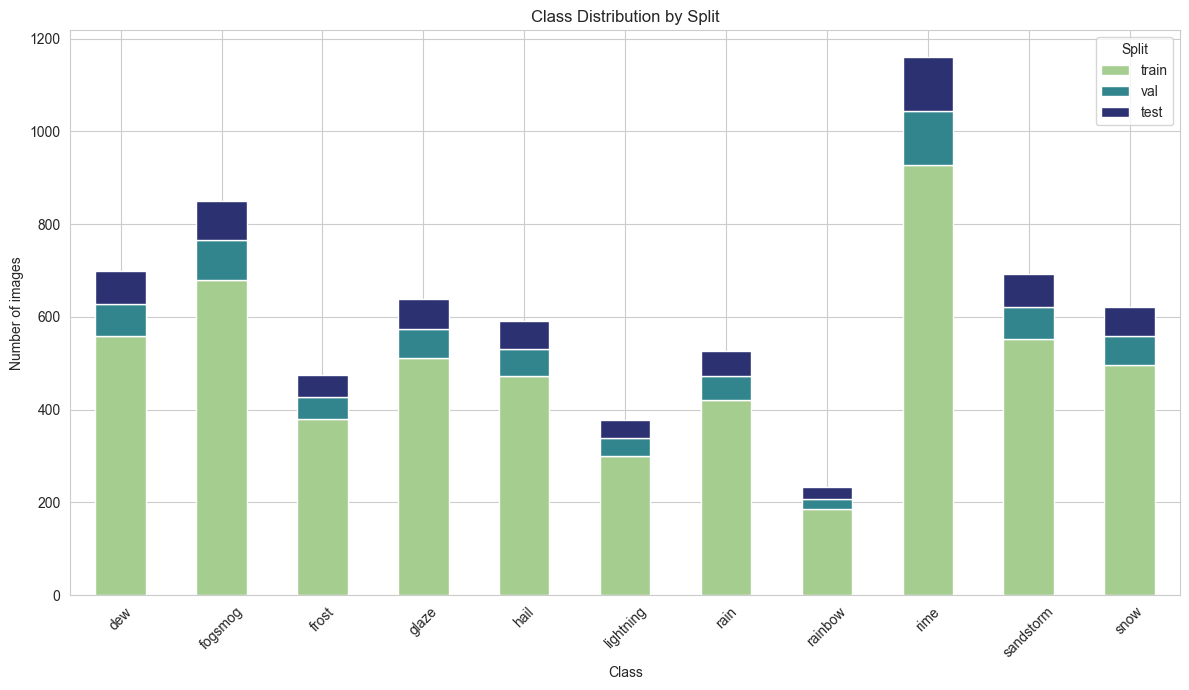

In [5]:
sns.set_style("whitegrid")

def count_classes_in_split(folder_path):
    counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            n_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            counts[class_name] = n_files
    return counts

def plot_class_distribution_grid(dest_folder):
    splits = ['train', 'val', 'test']
    total_counts = Counter()

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for split in splits:
        split_path = os.path.join(dest_folder, split)
        counts = count_classes_in_split(split_path)
        total_counts.update(counts)

    df_total = pd.DataFrame(list(total_counts.items()), columns=["Class", "Count"])
    norm = plt.Normalize(df_total["Count"].min(), df_total["Count"].max())
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
    bar_colors = [sm.to_rgba(c) for c in df_total["Count"]]

    axes[0].bar(df_total["Class"], df_total["Count"], color=bar_colors)
    axes[0].set_title("Class Distribution - Total")
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylabel("Número de imágenes")

    for i, split in enumerate(splits, start=1):
        split_path = os.path.join(dest_folder, split)
        counts = count_classes_in_split(split_path)
        df_split = pd.DataFrame(list(counts.items()), columns=["Class", "Count"])

        norm = plt.Normalize(df_split["Count"].min(), df_split["Count"].max())
        sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
        bar_colors = [sm.to_rgba(c) for c in df_split["Count"]]

        axes[i].bar(df_split["Class"], df_split["Count"], color=bar_colors)
        axes[i].set_title(f"{split.capitalize()} Split")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_ylabel("Number of Images")

    plt.tight_layout()
    save_path = os.path.join("../reports/figures/dataset_analysis", f"class_distribution_barchart.svg")
    plt.savefig(save_path, format="svg")
    plt.show()
    plt.close()

    print(f"Figure Saved in {save_path}")

dest_folder = "../data"
plot_class_distribution_grid(dest_folder)

sns.set_style("whitegrid")

def plot_stacked_distribution(dest_folder):
    splits = ['train', 'val', 'test']
    data = {}

    for split in splits:
        split_path = os.path.join(dest_folder, split)
        counts = count_classes_in_split(split_path)
        data[split] = counts

    df = pd.DataFrame(data).fillna(0).astype(int)

    ax = df.plot(kind="bar", stacked=True, figsize=(12,7), colormap="crest")

    plt.title("Class Distribution by Split")
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.xticks(rotation=45)
    plt.legend(title="Split")
    plt.tight_layout()
    save_path = os.path.join("../reports/figures/dataset_analysis", f"class_distribution_stacked.svg")
    plt.savefig(save_path, format="svg")
    plt.show()
    plt.close()

dest_folder = "../data"
plot_stacked_distribution(dest_folder)

### Dimension overview

https://www.kaggle.com/code/faldoae/exploratory-data-analysis-eda-for-image-datasets

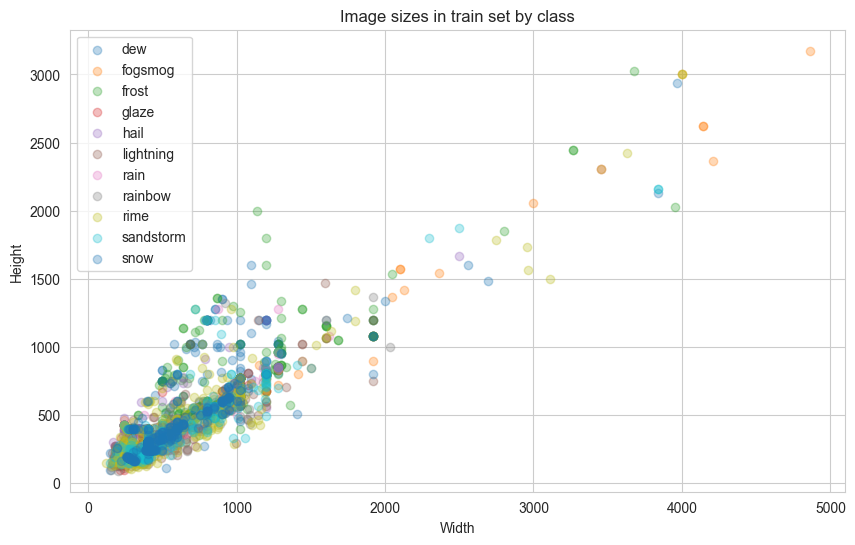

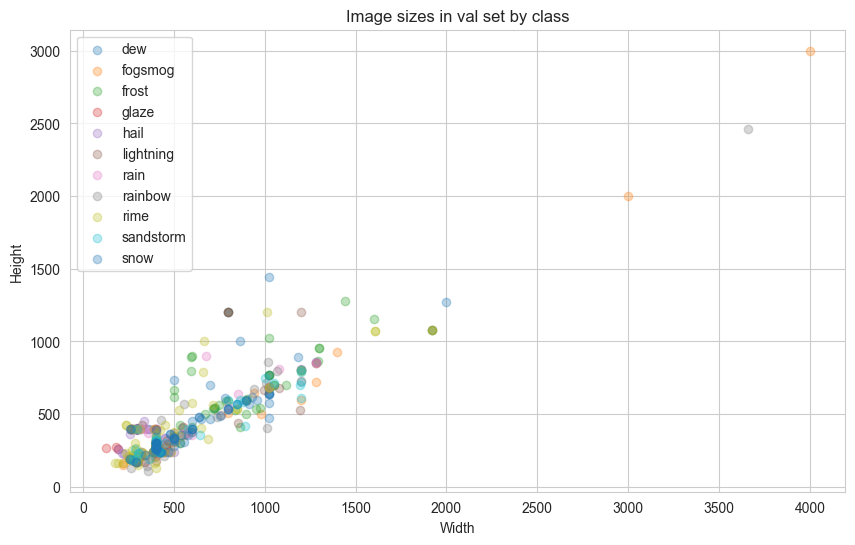

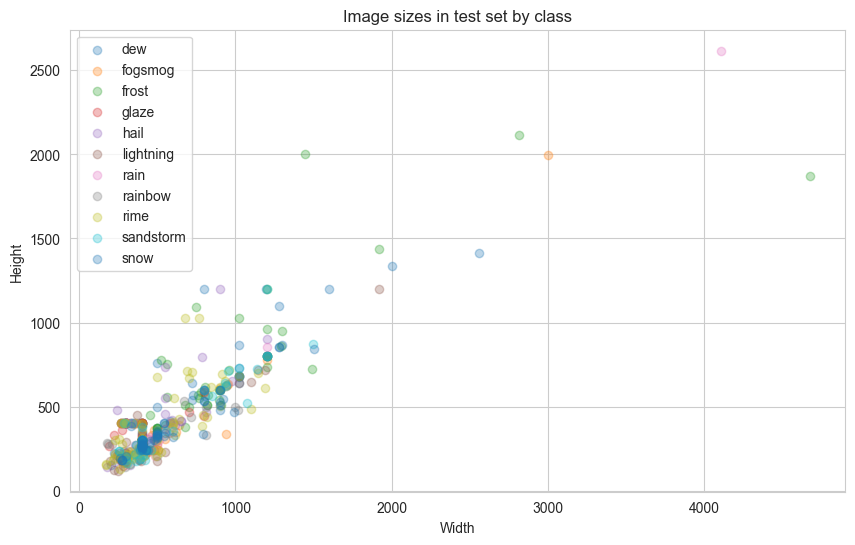

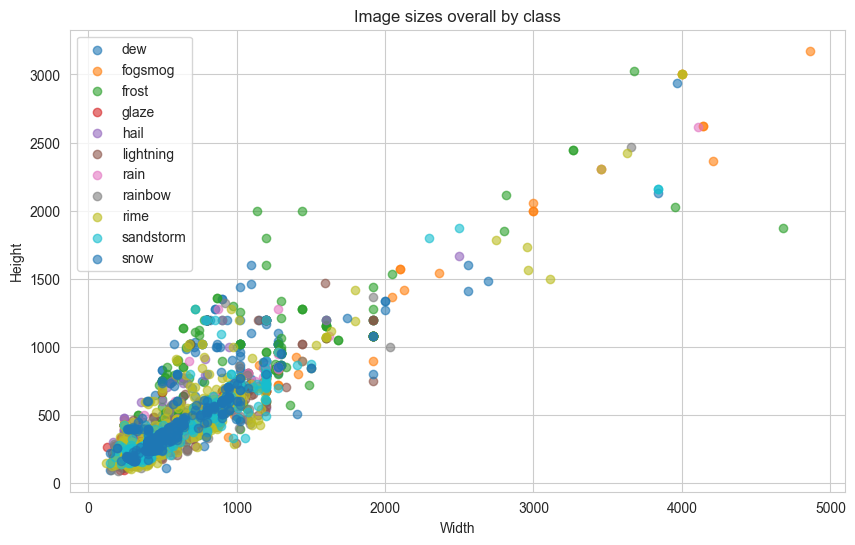

In [6]:
def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    if len(arr.shape) == 3:
        h, w, _ = arr.shape  # color image
    else:
        h, w = arr.shape     # grayscale image
    return h,w

def collect_image_sizes(data_folder):
    sizes = {}  # {split: {class: [(h,w), ...]}}
    overall = {}  # {class: [(h,w), ...]} disregarding split

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(data_folder, split)
        sizes[split] = {}
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png','jpg','jpeg'))]
            class_sizes = [get_dims(f) for f in files]
            sizes[split][class_name] = class_sizes

            if class_name not in overall:
                overall[class_name] = []
            overall[class_name].extend(class_sizes)

    return sizes, overall


def plot_sizes(sizes, overall):
    # 1. Plot by split and class
    for split, split_data in sizes.items():
        plt.figure(figsize=(10,6))
        for class_name, dims in split_data.items():
            heights = [h for h,w in dims]
            widths = [w for h,w in dims]
            plt.scatter(widths, heights, label=class_name, alpha=0.3)
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.title(f"Image sizes in {split} set by class")
        plt.legend()
        save_path = os.path.join("../reports/figures/dataset_analysis", f"image_sizes_{split}.svg")
        plt.savefig(save_path, format="svg")
        plt.show()
        plt.close()

    # 2. Overall plot by class
    plt.figure(figsize=(10,6))
    for class_name, dims in overall.items():
        heights = [h for h,w in dims]
        widths = [w for h,w in dims]
        plt.scatter(widths, heights, label=class_name, alpha=0.6)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image sizes overall by class")
    plt.legend()
    save_path = os.path.join("../reports/figures/dataset_analysis", f"image_size_overall.svg")
    plt.savefig(save_path, format="svg")
    plt.show()
    plt.close()

# Usage:
data_folder = "../data"  # your structured folder
sizes, overall = collect_image_sizes(data_folder)
plot_sizes(sizes, overall)

### Color analysis / Mean image

In [7]:
def get_all_class_images(data_folder):
    """Collects all images per class across train/val/test."""
    classes = {}
    for split in ["train", "val", "test"]:
        split_path = os.path.join(data_folder, split)
        if not os.path.exists(split_path):
            continue
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            files = [os.path.join(class_path, f) 
                     for f in os.listdir(class_path) 
                     if f.lower().endswith(("png","jpg","jpeg"))]
            if class_name not in classes:
                classes[class_name] = []
            classes[class_name].extend(files)
    return classes

def compute_mean_image(image_paths, size=(224,224)):
    """Compute mean image from a list of paths."""
    arrays = []
    for f in image_paths:
        try:
            im = Image.open(f).convert("RGB").resize(size)  # force RGB + resize
            arrays.append(np.array(im, dtype=np.float32))
        except Exception as e:
            print(f"Skipping {f}: {e}")
    if not arrays:
        return None
    mean_array = np.mean(arrays, axis=0).astype(np.uint8)
    return Image.fromarray(mean_array)

def plot_mean_images(class_images, size=(224,224), title="Mean Image per Class"):
    """Compute and plot mean image per class with tighter spacing."""
    
    n_classes = len(class_images)

    # Choose grid (close to square)
    n_cols = min(n_classes, 6)  # up to 5 per row
    n_rows = (n_classes + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = np.array(axes).reshape(-1)  # flatten for easy iteration

    for ax, (class_name, files) in zip(axes, class_images.items()):
        mean_img = compute_mean_image(files, size=size)
        if mean_img is not None:
            ax.imshow(mean_img)
            ax.set_title(class_name, fontsize=12)
        ax.axis("off")

    # Hide unused axes if classes < grid size
    for ax in axes[len(class_images):]:
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # push plots down a bit
    fig.suptitle(title, fontsize=18, y=0.98)  # position title above plots
    save_path = os.path.join("../reports/figures/dataset_analysis", f"mean_image_per_class.svg")
    plt.savefig(save_path, format="svg")
    plt.show()
    plt.close()


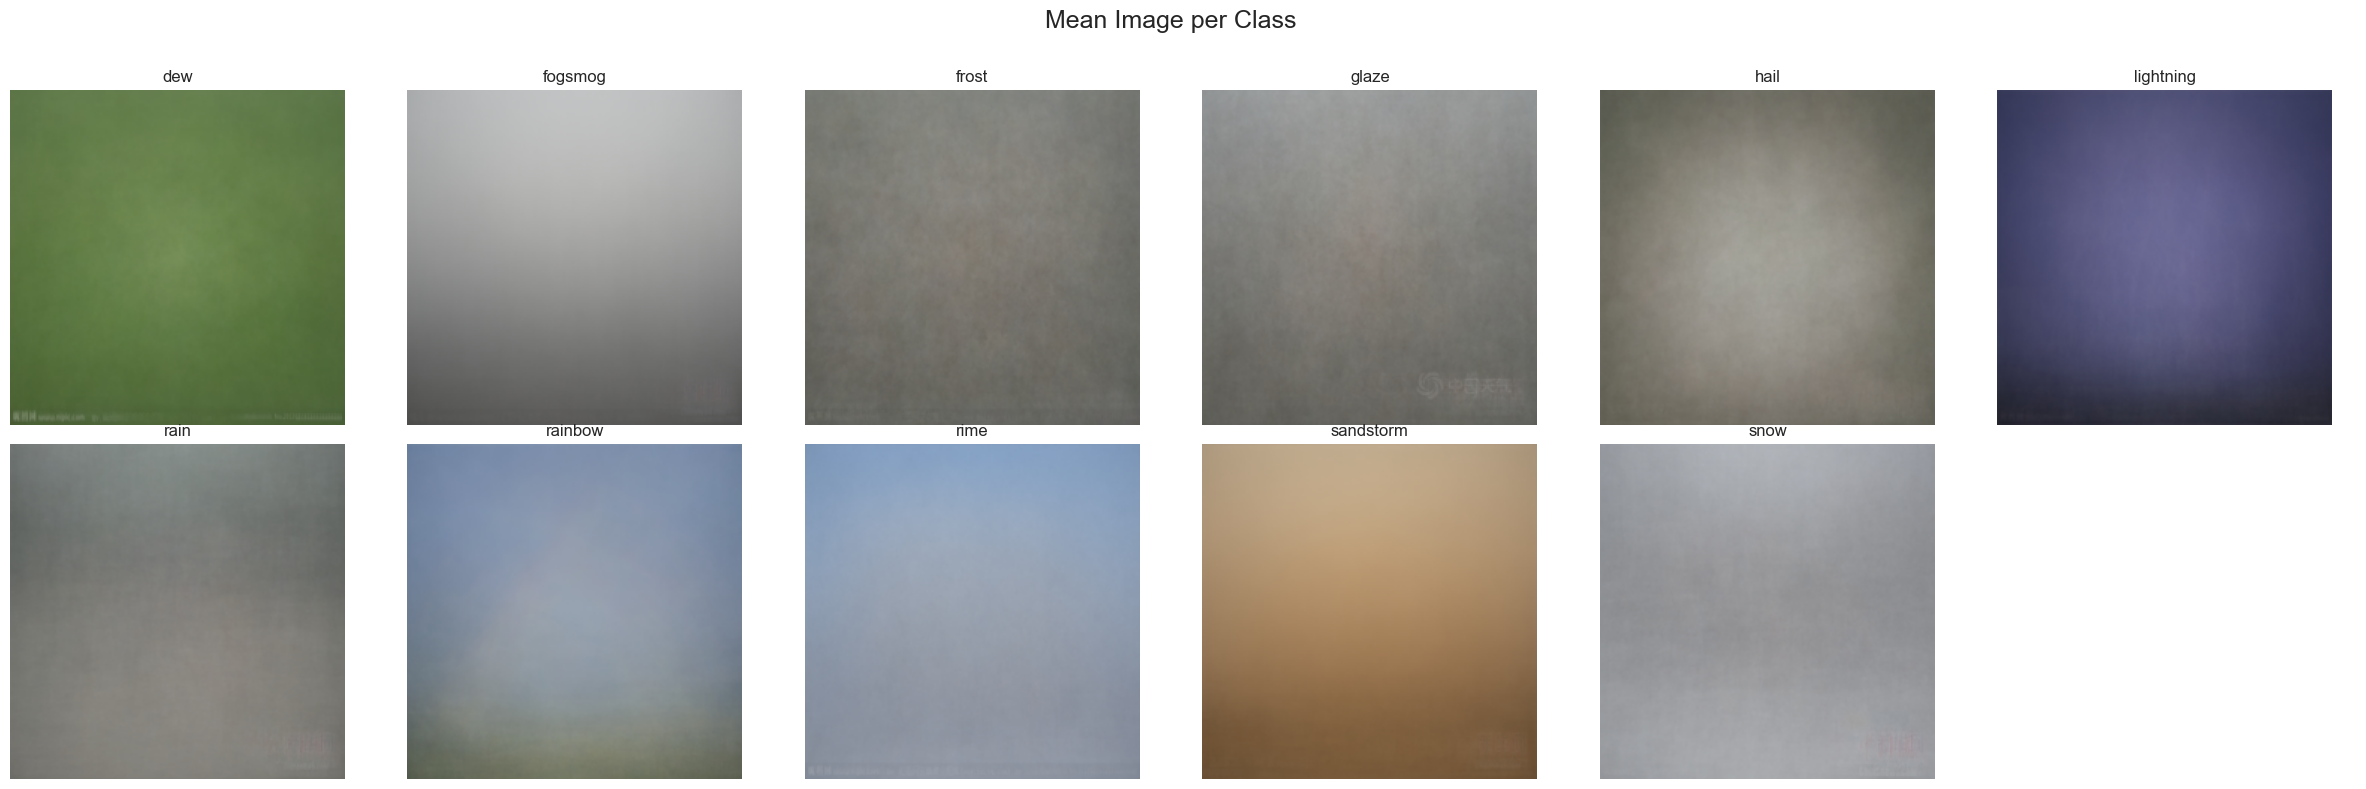

In [8]:
data_folder = "../data"
class_images = get_all_class_images(data_folder)

plot_mean_images(class_images, size=(224,224))

In [ ]:
folders = ["../data/train", "../data/val", "../data/test"]
for folder_path in folders:
    set = os.path.basename(folder_path)  # train / val / test
    title = f"Mean image per class in {set}"
    class_images = get_all_class_images(data_folder)
    plot_mean_images(class_images, size=(224,224), title=title)

: 

: 

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm  # for the progress bar


# ✅ Transform: resize + ToTensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to same size
    transforms.ToTensor()
])

# ✅ Load dataset
train_dataset = datasets.ImageFolder(root="../data/train", transform=transform)

# ✅ DataLoader with batch_size=1
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

# ✅ Initialize accumulators
mean = torch.zeros(3)
std = torch.zeros(3)
num_samples = 0

# ✅ Loop through dataset with progress bar
for images, _ in tqdm(train_loader, desc="Computing mean/std"):
    # images shape: (1, 3, H, W)
    images = images.view(1, 3, -1)  # flatten H*W per channel
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    num_samples += 1

# ✅ Compute final mean/std
mean /= num_samples
std /= num_samples

print(f"\n📊 Training dataset statistics:")
print(f"Mean: {mean}")
print(f"Std:  {std}")


Computing mean/std: 100%|██████████| 86/86 [00:34<00:00,  2.47it/s]


📊 Training dataset statistics:
Mean: tensor([0.5167, 0.5143, 0.5164])
Std:  tensor([0.2378, 0.2359, 0.2393])
